# Singapore Resale Flat Prices

The aim of this project is to analyze the resale flat prices in Singapore, and to build a model which is capable of accurately predicting resale flat prices in Singapore.

The data used in this project is available from: https://data.gov.sg/dataset/resale-flat-prices.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

import time
import os
import pickle

The data is organized by registration/approval date from 1990 - present in 5 .csv files. As property prices tend to change from year to year depending on factors such as the economy etc., it would be best to separate the analysis based on a well specified time span. 

In [2]:
# The raw data used in this script can be downloaded from my GitHub repository:
# https://github.com/natsunoyuki/Data_Science/tree/master/resale_flat_prices/raw_data
base_path = 'raw_data/'

Data = []

cols = []
for f in os.listdir(base_path):
    if f[:18] == "resale-flat-prices":
        print(f)
        path = base_path + f
        data = pd.read_csv(path, compression = "zip")
        print('Loaded data shape:',data.shape)
        print("Loaded data columns:",data.columns)
        Data.append(data)
        cols.append(data.columns)

resale-flat-prices-based-on-approval-date-2000-feb-2012.csv.zip
Loaded data shape: (369651, 10)
Loaded data columns: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')
resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv.zip
Loaded data shape: (52203, 10)
Loaded data columns: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')
resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv.zip
Loaded data shape: (100866, 11)
Loaded data columns: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')
resale-flat-prices-based-on-registration-date-from-jan-2015-to

## Part 1

For the first part of this notebook, we will analyze all data points for 1990 - present. In particular, we want to find out how median prices have changed over time since 1990.

As the columns of each file are different, we should standardize the columns of the various DataFrames. Keep the following columns: 

`['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price']`.

We also combine the data from the various individual `.csv` files together into 1 `DataFrame`.

In [3]:
cols_to_keep = ['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 
                'flat_model', 'lease_commence_date', 'resale_price']

data = pd.DataFrame()
for dat in Data:
    dat = dat[cols_to_keep]
    display(dat.head(1))
    data = pd.concat([data, dat], axis = 0) # Combine the various data together into 1 DataFrame.

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,232000.0


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,255000.0


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000


In [4]:
print("Final merged shape:",data.shape)
display(data.head())

Final merged shape: (847069, 10)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2000-01,ANG MO KIO,3 ROOM,170,ANG MO KIO AVE 4,07 TO 09,69.0,Improved,1986,147000.0
1,2000-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,144000.0
2,2000-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,159000.0
3,2000-01,ANG MO KIO,3 ROOM,215,ANG MO KIO AVE 1,07 TO 09,73.0,New Generation,1976,167000.0
4,2000-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,07 TO 09,67.0,New Generation,1976,163000.0


There are more than 800000 resales over a time span of about 30 years. This implies an average of 27000 resales per year! Also note that we should not use all data points to construct the model, as prices change from year to year and also because of inflation etc. Therefore we should perhaps take the data from the most recent years.

Also, the format of the data in the columns are not standardized, e.g. under flat_model we have `Improved` and `IMPROVED`, `New Generation` and `NEW GENERATION`. We will need to clean up the data and standardize the format of the raw data, and then perform encoding of the raw data to numerical form!

### Preprocessing `Month`

`month` contains both the year and month of resale. Extract the year and plot the number of resales per year.

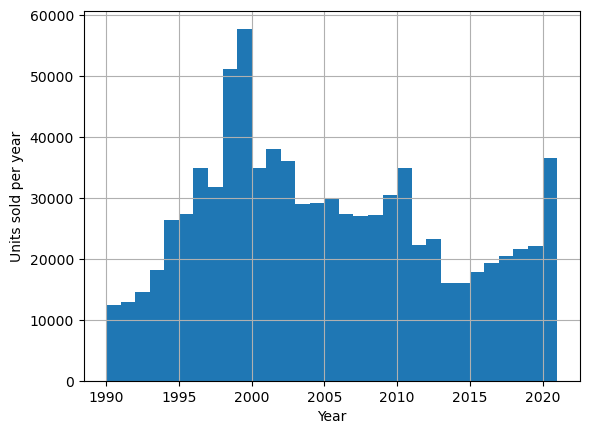

In [5]:
# Clean up the date format in the column month.
def month_formatter(x):
    # converts 2017-01 to 201701 int format
    return int(x[:4])*100 + int(x[5:])

def year_from_month(x):
    # converts 2017-01 to 2017 int format
    return int(x[:4])

def mth_from_month(x):
    # converts 2017-01 to 1 int format
    return int(x[5:])

# Extract the resale year, and check the distribution
data['year'] = data['month'].apply(year_from_month)

plt.hist(data['year'], data['year'].max() - data['year'].min())
plt.xlabel('Year')
plt.ylabel('Units sold per year')
plt.grid('on')
plt.show()

It seems that majority of resales occur during just before 2000. We think that this is closely related to the 1997 Asian financial crisis which caused a recession in East Asia + South East Asia during 1997 - 1999. Perhaps this crisis forced some people to sell their flats for income? Surprisingly, there is not corresponding large peak during the Lehmann shock period of 2007 - 2009. Perhaps because no potential resale buyers were found due to the severe world wide recession? Also in particular, there is a low during 2013 ~ 2015... We are not too sure about any world wide or local events which correspond to this... Also there is a sudden peak in 2020 corresponding to the start of the coronavirus outbreak. 

Also, check if the month has any effect on the sales.

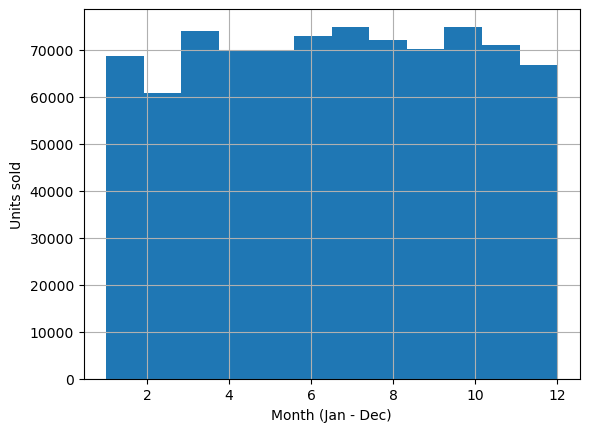

In [6]:
# Extract the resale month and check the distribution.
data['mth'] = data['month'].apply(mth_from_month)

plt.hist(data['mth'], 12)
plt.xlabel('Month (Jan - Dec)')
plt.ylabel('Units sold')
plt.grid('on')
plt.show()

There does not seem to be a huge variation in the number of resale units throughout the 12 months! So the total resales are pretty constant throughout the year. Perhaps we should do this analysis year by year? But then this means that we will have 30 years to go through.

Make a time series plot of the number of resales by year-month to observe any local trends.

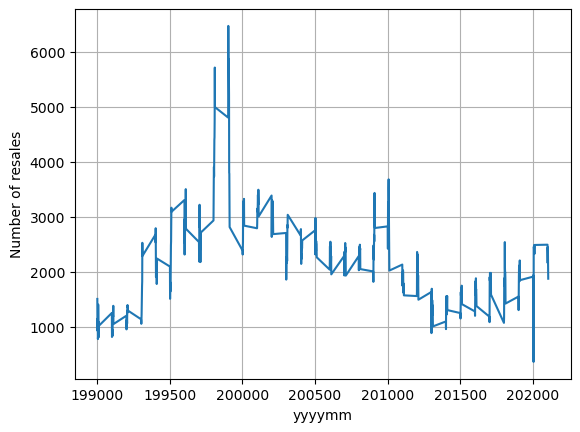

In [7]:
# Format the resale year and month to yyyymm integer format.
data['year_month'] = data['month'].apply(month_formatter)

# Sort the all the data from earliest 199001 to latest 202003.
data = data.sort_values('year_month')

data_groupby = data.copy()
data_groupby['counter'] = 1
data_groupby = data_groupby[['year_month','counter']]
data_groupby = data_groupby.groupby('year_month').sum().reset_index()

plt.plot(data_groupby['year_month'],data_groupby['counter'])
plt.xlabel('yyyymm')
plt.ylabel("Number of resales")
plt.grid('on')
plt.show()

We do not gain much new information from this time series, with the exception of the peak corresponding to the 1997 Asian financial crisis and a second small peak corresponding to the Lehmann shock. We guess that these peaks correspond to people selling their apartments for cash during economically hard times rather than there being a good market for apartments...

Also do a time series to track how the prices change over time? That might be a more educational indicator than the total number of resales as a time series!

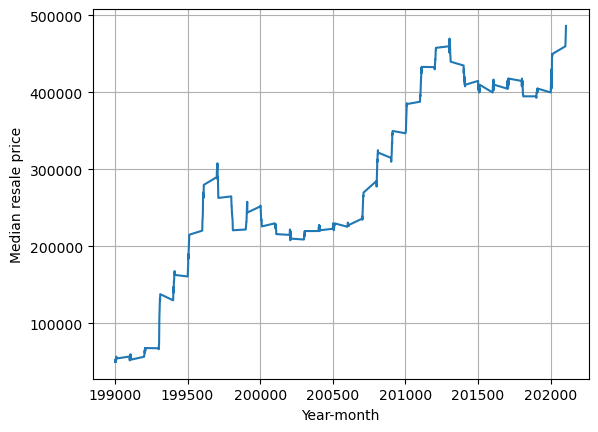

In [8]:
# TO-DO: implement a time series plot of resale price with time.
tmp = data[["year_month", "resale_price"]].groupby("year_month").median().reset_index().sort_values('year_month')

# WARNING! Due to the wide spread of resale prices for the different apartment types, we do not take the mean
# but take the median instead to prevent outliers from affecting the results.

plt.plot(tmp['year_month'],tmp['resale_price'])
plt.xlabel('Year-month')
plt.ylabel('Median resale price')
plt.grid('on')
plt.show()

We are still checking, but the resale prices for the past are probably not adjusted for inflation, which should be taken into account when comparing past prices and current prices!

It appears that there are two local peaks... one peak corresponds to the 1997 Asian financial crisis and the dot-com bubble. Due to the 1997 Asian financial crisis we expected the resale prices to decrease especially with the sudden spike in the number of units resold (see graph above) leading to a sudden increase in the supply of flats. Perhaps the dot-com bubble had a stronger effect on the resale prices. The second peak corresponds to around 2012 - 2013 which is about half a decade after the Lehmann shock. We are not too familiar with the historical economic situation of Singapore, and would be very glad if someone could help us here!

## Part 2

In this part we preprocess and clean up the rest of the features.

### Preprocessing `town`

`town` contains the name of the town of the flat. 

In [9]:
print(data['town'].value_counts())

TAMPINES           74607
YISHUN             64429
BEDOK              62549
JURONG WEST        61813
WOODLANDS          59828
ANG MO KIO         49031
HOUGANG            46541
BUKIT BATOK        40968
CHOA CHU KANG      34323
BUKIT MERAH        31328
PASIR RIS          30964
TOA PAYOH          29189
QUEENSTOWN         26627
CLEMENTI           26270
GEYLANG            26219
SENGKANG           25848
BUKIT PANJANG      25071
KALLANG/WHAMPOA    24619
JURONG EAST        23284
SERANGOON          21510
BISHAN             19995
PUNGGOL            14261
SEMBAWANG          11330
MARINE PARADE       7534
CENTRAL AREA        6521
BUKIT TIMAH         2346
LIM CHU KANG          64
Name: town, dtype: int64


All the names are standardized to capital letters so we do not need to worry about the formatting. What we need to do is some sort of encoding to encode the town names numerically. We choose not to do one hot encoding as this will lead to a sudden increase in the number of cols.

Encode the town names numerically using a dictionary. We can use a reverse dictionary later on to reverse the encoding to get the names from numbers

In [10]:
town = {}
for i,j in enumerate(sorted(data.town.unique())):
    town[j] = i

print(town)

# Make a reverse dictionary? 
data['town_num'] = data['town'].apply(lambda x: town[x]) 
#display(data[['town','town_num']].head())

# Also, we have another idea on how to treat the town data. The idea could be potentially marketable as a new
# technology and we will not be making public the idea.
# TO-DO: implement new idea ASAP!!!

{'ANG MO KIO': 0, 'BEDOK': 1, 'BISHAN': 2, 'BUKIT BATOK': 3, 'BUKIT MERAH': 4, 'BUKIT PANJANG': 5, 'BUKIT TIMAH': 6, 'CENTRAL AREA': 7, 'CHOA CHU KANG': 8, 'CLEMENTI': 9, 'GEYLANG': 10, 'HOUGANG': 11, 'JURONG EAST': 12, 'JURONG WEST': 13, 'KALLANG/WHAMPOA': 14, 'LIM CHU KANG': 15, 'MARINE PARADE': 16, 'PASIR RIS': 17, 'PUNGGOL': 18, 'QUEENSTOWN': 19, 'SEMBAWANG': 20, 'SENGKANG': 21, 'SERANGOON': 22, 'TAMPINES': 23, 'TOA PAYOH': 24, 'WOODLANDS': 25, 'YISHUN': 26}


## Preprocessing `street_name`

`street_name` contains the name of the street of the flat.

In [11]:
# Check the format of street_name.

print("Total number of unique street names:",len(data['street_name'].unique()))

display(data['street_name'].head())

Total number of unique street names: 572


0       ANG MO KIO AVE 1
1010        BENDEMEER RD
1009     ST. GEORGE'S RD
1008         KG ARANG RD
1007             OWEN RD
Name: street_name, dtype: object

Surprisingly there are only 565 unique street names. It would appear that Singapore is "smaller" then expected.

Also, the property's address is constructed from the `block` + `street_name`!

In [12]:
# Do a check in all the addresses for non-alphabetical characters.

problem_data = data['street_name'].apply(lambda x: True if "'" in x else False)
problem_data = data[problem_data]

print(np.shape(problem_data))
display(problem_data.head())

(10942, 14)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,mth,year_month,town_num
1009,1990-01,KALLANG/WHAMPOA,3 ROOM,20,ST. GEORGE'S RD,04 TO 06,67.0,NEW GENERATION,1984,66500.0,1990,1,199001,14
1028,1990-01,KALLANG/WHAMPOA,5 ROOM,807,KING GEORGE'S AVE,07 TO 09,115.0,IMPROVED,1981,153000.0,1990,1,199001,14
1025,1990-01,KALLANG/WHAMPOA,4 ROOM,23,ST. GEORGE'S RD,01 TO 03,91.0,NEW GENERATION,1984,100000.0,1990,1,199001,14
972,1990-01,KALLANG/WHAMPOA,3 ROOM,2,ST. GEORGE'S RD,07 TO 09,59.0,IMPROVED,1976,45700.0,1990,1,199001,14
1076,1990-01,QUEENSTOWN,2 ROOM,55,C'WEALTH DR,04 TO 06,46.0,STANDARD,1970,14000.0,1990,1,199001,19


In [13]:
street_name_list = data['street_name'].unique()

# Do a visual check just to be sure...

#print(sorted(street_name_list))
for s in sorted(street_name_list):
    print(s)

ADMIRALTY DR
ADMIRALTY LINK
AH HOOD RD
ALEXANDRA RD
ALJUNIED CRES
ALJUNIED RD
ANCHORVALE CRES
ANCHORVALE DR
ANCHORVALE LANE
ANCHORVALE LINK
ANCHORVALE RD
ANCHORVALE ST
ANG MO KIO AVE 1
ANG MO KIO AVE 10
ANG MO KIO AVE 2
ANG MO KIO AVE 3
ANG MO KIO AVE 4
ANG MO KIO AVE 5
ANG MO KIO AVE 6
ANG MO KIO AVE 8
ANG MO KIO AVE 9
ANG MO KIO ST 11
ANG MO KIO ST 21
ANG MO KIO ST 31
ANG MO KIO ST 32
ANG MO KIO ST 52
ANG MO KIO ST 61
BAIN ST
BALAM RD
BANGKIT RD
BEACH RD
BEDOK CTRL
BEDOK NTH AVE 1
BEDOK NTH AVE 2
BEDOK NTH AVE 3
BEDOK NTH AVE 4
BEDOK NTH RD
BEDOK NTH ST 1
BEDOK NTH ST 2
BEDOK NTH ST 3
BEDOK NTH ST 4
BEDOK RESERVOIR CRES
BEDOK RESERVOIR RD
BEDOK RESERVOIR VIEW
BEDOK STH AVE 1
BEDOK STH AVE 2
BEDOK STH AVE 3
BEDOK STH RD
BENDEMEER RD
BEO CRES
BISHAN ST 11
BISHAN ST 12
BISHAN ST 13
BISHAN ST 22
BISHAN ST 23
BISHAN ST 24
BOON KENG RD
BOON LAY AVE
BOON LAY DR
BOON LAY PL
BOON TIONG RD
BRIGHT HILL DR
BT BATOK CTRL
BT BATOK EAST AVE 3
BT BATOK EAST AVE 4
BT BATOK EAST AVE 5
BT BATOK ST 11
B

We need to clean up the `street_name`. For example, C'WEALTH should be rendered as COMMONWEALTH. There might be other similar weird cases as well...

There are many short form words which should be cleaned up...

In [14]:
# For tidiness' sake, replace ALL short forms with the proper words

def street_name_cleaner(x):
    #if " DR " in x: 
    #    x = x.replace(" DR "," DRIVE ")
    #if " RD " in x: 
    #    x = x.replace(" RD "," ROAD ")
    #if " ST " in x: 
    #    x = x.replace(" ST "," STREET ")
    #if " AVE " in x: 
    #    x = x.replace(" AVE "," AVENUE ")
    #if " CTRL " in x: 
    #    x = x.replace(" CTRL "," CENTRAL ")
    if "NTH" in x:
        x = x.replace("NTH", "NORTH")
    if "STH" in x:
        x = x.replace("STH", "SOUTH")
    #if " PL " in x: 
    #    x = x.replace(" PL "," PLACE ")
    if "BT" in x:
        x = x.replace("BT", "BUKIT")
    if "JLN" in x:
        x = x.replace("JLN", "JALAN")
    if "C'WEALTH" in x:
        x = x.replace("C'WEALTH", "COMMONWEALTH")
    if "KG" in x:
        x = x.replace("KG", "KAMPONG")
    if "LOR " in x:
        x = x.replace("LOR ", "LORONG ")
    if "MKT" in x:
        x = x.replace("MKT", "MARKET")
    if "PK" in x:
        x = x.replace("PK", "PARK")
    if "HTS" in x:
        x = x.replace("HTS", "HEIGHTS")
    if "UPP" in x:
        x = x.replace("UPP","UPPER")
    if "TG" in x:
        x = x.replace("TG","TANJONG")
    #if "TER" in x: 
    #    x = x.replace("TER","TERRACE")
    #if "GDNS" in x: 
    #    x = x.replace("GDNS","GARDENS")
    return x

# Clean up the street names.
data['street_name'] = data['street_name'].apply(street_name_cleaner)
street_name_list = data['street_name'].unique()

# Do a visual check again one more time...
#print(sorted(street_name_list))
for s in sorted(street_name_list):
    print(s)

ADMIRALTY DR
ADMIRALTY LINK
AH HOOD RD
ALEXANDRA RD
ALJUNIED CRES
ALJUNIED RD
ANCHORVALE CRES
ANCHORVALE DR
ANCHORVALE LANE
ANCHORVALE LINK
ANCHORVALE RD
ANCHORVALE ST
ANG MO KIO AVE 1
ANG MO KIO AVE 10
ANG MO KIO AVE 2
ANG MO KIO AVE 3
ANG MO KIO AVE 4
ANG MO KIO AVE 5
ANG MO KIO AVE 6
ANG MO KIO AVE 8
ANG MO KIO AVE 9
ANG MO KIO ST 11
ANG MO KIO ST 21
ANG MO KIO ST 31
ANG MO KIO ST 32
ANG MO KIO ST 52
ANG MO KIO ST 61
BAIN ST
BALAM RD
BANGKIT RD
BEACH RD
BEDOK CTRL
BEDOK NORTH AVE 1
BEDOK NORTH AVE 2
BEDOK NORTH AVE 3
BEDOK NORTH AVE 4
BEDOK NORTH RD
BEDOK NORTH ST 1
BEDOK NORTH ST 2
BEDOK NORTH ST 3
BEDOK NORTH ST 4
BEDOK RESERVOIR CRES
BEDOK RESERVOIR RD
BEDOK RESERVOIR VIEW
BEDOK SOUTH AVE 1
BEDOK SOUTH AVE 2
BEDOK SOUTH AVE 3
BEDOK SOUTH RD
BENDEMEER RD
BEO CRES
BISHAN ST 11
BISHAN ST 12
BISHAN ST 13
BISHAN ST 22
BISHAN ST 23
BISHAN ST 24
BOON KENG RD
BOON LAY AVE
BOON LAY DR
BOON LAY PL
BOON TIONG RD
BRIGHT HILL DR
BUANGKOK CRES
BUANGKOK GREEN
BUANGKOK LINK
BUANGKOK SOUTH FARMWA

Create a new feature `address` from `block` and `street name`.

In [15]:
#data = data.sort_values(["street_name","block"])
data["address"] = data['block'] + " " + data['street_name']
display(data.head())

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,mth,year_month,town_num,address
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,1990,1,199001,0,309 ANG MO KIO AVE 1
1010,1990-01,KALLANG/WHAMPOA,3 ROOM,44,BENDEMEER RD,04 TO 06,63.0,STANDARD,1981,31400.0,1990,1,199001,14,44 BENDEMEER RD
1009,1990-01,KALLANG/WHAMPOA,3 ROOM,20,ST. GEORGE'S RD,04 TO 06,67.0,NEW GENERATION,1984,66500.0,1990,1,199001,14,20 ST. GEORGE'S RD
1008,1990-01,KALLANG/WHAMPOA,3 ROOM,14,KAMPONG ARANG RD,04 TO 06,103.0,NEW GENERATION,1984,77000.0,1990,1,199001,14,14 KAMPONG ARANG RD
1007,1990-01,KALLANG/WHAMPOA,3 ROOM,46,OWEN RD,01 TO 03,68.0,NEW GENERATION,1982,58000.0,1990,1,199001,14,46 OWEN RD


Check the total number of unique addresses. Remember that we only had 565 unique street names!

In [16]:
print("Total number of unique addresses:", len(data['address'].unique()))

Total number of unique addresses: 9423


That is a huge increase! The address might be too localised to result in a good data set to use for the model... The street_name is more general and might give a better representation of the area!

We use a trick to encode the addresses numerically. The trick below is to sort the encoding by `street_name` so all similar street names will be close to each other numerically. If the addresses were sorted normally, the addresses would be sorted by `block` and block numbers close to each other would be close to each other numerically which would not make sense...

In [17]:
# Encode the addresses numerically!

tmp = data[["street_name", "block"]]
tmp = tmp.sort_values(["street_name", "block"])
tmp['address'] = tmp['street_name'] + "/" + tmp['block'] 

unique_addresses = sorted(tmp["address"].unique())

addresses = {}

for i,j in enumerate(unique_addresses):
    # The trick below is to allow me to sort the encoding by street name
    # so all similar street names will be close to each other numerically
    # If the addresses were sorted normally, the addresses would be sorted
    # by block and block numbers close to each other would be close to each
    # other numerically which would not make sense...
    address_to_encode = j.split('/')[1] + " " + j.split('/')[0]
    #print(address_to_encode)
    addresses[address_to_encode] = i

# Make a reverse dictionary?
    
data['address_num'] = data['address'].apply(lambda x: addresses[x]) 
display(data[['address', 'address_num']].head())

,address,address_num
0,309 ANG MO KIO AVE 1,201
1010,44 BENDEMEER RD,970
1009,20 ST. GEORGE'S RD,6978
1008,14 KAMPONG ARANG RD,4691
1007,46 OWEN RD,5273


In [18]:
# Encode the street name numerically.
street_names = {}

for i,j in enumerate(sorted(data['street_name'].unique())):
    street_names[j] = i
    
data["street_name_num"] = data['street_name'].apply(lambda x: street_names[x])
display(data[['street_name', 'street_name_num']].head())

,street_name,street_name_num
0,ANG MO KIO AVE 1,12
1010,BENDEMEER RD,48
1009,ST. GEORGE'S RD,433
1008,KAMPONG ARANG RD,278
1007,OWEN RD,338


## Preprocessing `flat_type`

`flat_type` contains information about the flat type:

In [19]:
# Now we verify the data inside the column flat_type

display(data['flat_type'].value_counts())

# The standardization is more or less good enough with the exception of MULTI GENERATION and MULTI-GENERATION
# so we have to take that into account during the encoding. We do not use one hot encoding, and numerically 
# encode to integers instead to prevent the number of columns from increasing too much!

4 ROOM              317952
3 ROOM              276945
5 ROOM              175914
EXECUTIVE            64316
2 ROOM               10142
1 ROOM                1284
MULTI GENERATION       279
MULTI-GENERATION       237
Name: flat_type, dtype: int64

Encode the flat type using numerical integers. In particular, we use a logarithimic scale for the encoding to represent the value of the flat (cheap -> expensive).

In [20]:
def flat_type_formatter(x):
    if x == '1 ROOM':
        res = 1
    elif x == '2 ROOM':
        res = 10
    elif x == '3 ROOM':
        res = 100
    elif x == '4 ROOM':
        res = 1000
    elif x == '5 ROOM':
        res = 10000
    elif x == 'EXECUTIVE':
        res = 100000
    elif x == 'MULTI-GENERATION' or x == "MULTI GENERATION":
        res = 1000000
    else:
        res = -999999 #error value
    return res
    
data['flat_type_num'] = data['flat_type'].apply(flat_type_formatter)

display(data[['flat_type', 'flat_type_num']].head())

,flat_type,flat_type_num
0,1 ROOM,1
1010,3 ROOM,100
1009,3 ROOM,100
1008,3 ROOM,100
1007,3 ROOM,100


## Preprocessing `storey_range`

`storey_range` contains information about which floor the apartment is located on. Unfortunately, the exact floor is not made public.

In [21]:
print(data['storey_range'].value_counts())

04 TO 06    214398
07 TO 09    193282
01 TO 03    172561
10 TO 12    163917
13 TO 15     54260
16 TO 18     20453
19 TO 21      9856
22 TO 24      6376
25 TO 27      2742
01 TO 05      2700
06 TO 10      2474
11 TO 15      1259
28 TO 30      1156
31 TO 33       340
34 TO 36       336
37 TO 39       322
16 TO 20       265
40 TO 42       158
21 TO 25        92
26 TO 30        39
43 TO 45        32
46 TO 48        31
49 TO 51        11
36 TO 40         7
31 TO 35         2
Name: storey_range, dtype: int64


The column storey_range is in a format which cannot be used  directly in the modelling, e.g. `04 TO 06`. We simply solve the problem by taking the number on the left of `TO` i.e. `04 TO 06` -> `4`.

In [22]:
# This encoding will allow us to use the storey_range directly in the model without doing much wrangling.

def storey_range_formatter(x):
    return int(x[:2])

data['storey_range_num'] = data['storey_range'].apply(storey_range_formatter)
display(data[['storey_range','storey_range_num']].head())

,storey_range,storey_range_num
0,10 TO 12,10
1010,04 TO 06,4
1009,04 TO 06,4
1008,04 TO 06,4
1007,01 TO 03,1


## Preprocessing `flat_model`

`flat_model` contains information about the flat model. This is different from `flat_type`. 

In [23]:
# Now we need to take a look at the column: flat_model

display(data['flat_model'].value_counts())

Model A                   164745
Improved                  148929
New Generation            100966
NEW GENERATION             78898
IMPROVED                   73589
MODEL A                    70381
Premium Apartment          37614
Simplified                 31387
SIMPLIFIED                 23258
Standard                   23085
Apartment                  22931
STANDARD                   17375
Maisonette                 15355
MAISONETTE                 12215
APARTMENT                   9901
Model A2                    9288
DBSS                        2139
Adjoined flat               1126
MODEL A-MAISONETTE           982
Model A-Maisonette           950
Terrace                      412
Type S1                      312
MULTI GENERATION             279
TERRACE                      247
Multi Generation             237
Type S2                      153
Premium Maisonette            83
Improved-Maisonette           72
Premium Apartment Loft        67
IMPROVED-MAISONETTE           44
2-room    

The `str` data inside this column is a huge mess with some entries in all capital letters e.g. `New Generation` and `NEW GENERATION`. Also, we are not familiar with how flats and apartments are classified in Singapore, e.g. what is the difference between `Model A` and `Model A2`, or `Premium Maisonette` and `Improved-Maisonette`. We could definitely use some help here from someone who knows well about flats in Singapore!

In [24]:
# Convert everything into all capital letters
data['flat_model'] = data['flat_model'].apply(lambda x: x.upper())

display(data['flat_model'].value_counts())

MODEL A                   235126
IMPROVED                  222518
NEW GENERATION            179864
SIMPLIFIED                 54645
STANDARD                   40460
PREMIUM APARTMENT          37620
APARTMENT                  32832
MAISONETTE                 27570
MODEL A2                    9288
DBSS                        2139
MODEL A-MAISONETTE          1932
ADJOINED FLAT               1126
TERRACE                      659
MULTI GENERATION             516
TYPE S1                      312
TYPE S2                      153
IMPROVED-MAISONETTE          116
PREMIUM MAISONETTE            83
PREMIUM APARTMENT LOFT        67
2-ROOM                        43
Name: flat_model, dtype: int64

This has helped to clean up the data. There are still many types which we am not familiar with, but we will not remove any types from now and simply use all the data.

We will use numerical encoding again to encode the flat models. We are not too sure about how flat models are classified in Singapore (not too much detailed information online) so we will simply assume that the most common flat models are the cheapest and the least common are the most expensive... We admit that this is a huge assumption and might be wrong!

In [25]:
x = data['flat_model'].value_counts()
#print(x)

flat_model = {}
for i,j in enumerate(x.index):
    flat_model[j] = i*10

data['flat_model_num'] = data['flat_model'].apply(lambda x: flat_model[x])

display(data[['flat_model', 'flat_model_num']].head())

,flat_model,flat_model_num
0,IMPROVED,10
1010,STANDARD,40
1009,NEW GENERATION,20
1008,NEW GENERATION,20
1007,NEW GENERATION,20


## Preprocessing `floor_area_sqm`

`floor_area_sqm` contains information about the size of the flat.

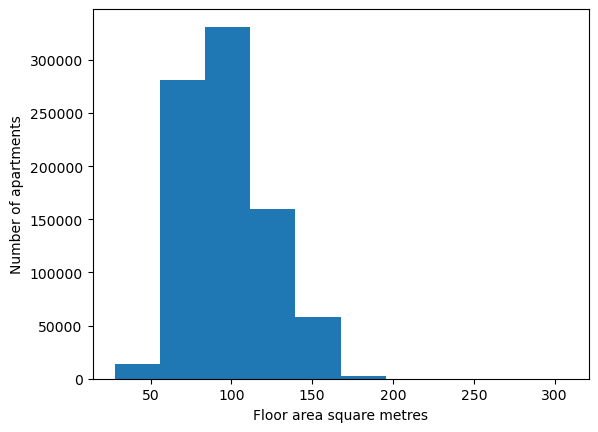

In [26]:
plt.hist(data['floor_area_sqm'])
plt.xlabel("Floor area square metres")
plt.ylabel("Number of apartments")
plt.show()

## Part 3

Specify the features to use in the modelling process!

`town_num`, `street_name_num` and `address_num` are all describing location at different scales. `town_num` is the least precise, followed by `street_name_num` and `address_num`. Note that `address_num` contains information from `street_name_num`. The problem with using address_num is that some addresses are very rare and do not contribute much to the model

Also, we use `flat_type_num`: `[1 ROOM - MULTI GENERATION]`, `storey_range_num`, `floor_area_sqm` and `lease_commence_date`. 

Post test comments: it would appear that `flat_type_num` does not really contribute much to the model!

These derive from "traditional wisdom". Ground floor apartments tend to be cheaper than those on higher floors, larger flats tend to be more expensive than small ones, and new flats should be more expensive than old ones due to aging infrastructure.

We exclude `flat_model_num`: `[MODEL A, IMPROVED, NEW GENERATION...]` as most buyers/sellers are unlikely to be able to tell the difference between the various different models.

We also want to take a look at how the various features relate to each other. Perhaps calculate the correlation matrix for the features we would like to use in the modelling process.

Now we simply need to extract the features to build the model with. Also we need to specify the range of resale years to use...

For now, we simply use the data for 2020 ~ present. As mentioned earlier this is because we want the latest prices! Prices from 10+ years ago do not really matter to us!

In [27]:
features = ['town_num',
            #'street_name_num',
            'address_num',
            #'flat_type_num',
            'storey_range_num',
            'floor_area_sqm',
            #'flat_model_num',
            'lease_commence_date']

target = 'resale_price'

condn = data['year'] >= 2020
data_to_use = data[condn]

# For modelling we will not touch data directly but rely on X and y!
X = data_to_use[features]
y = data_to_use[target]

print("Feature matrix shape:",np.shape(X))
print("Target matrix shape:",np.shape(y))

Feature matrix shape: (36610, 5)
Target matrix shape: (36610,)


Check for correlations between the various variables!

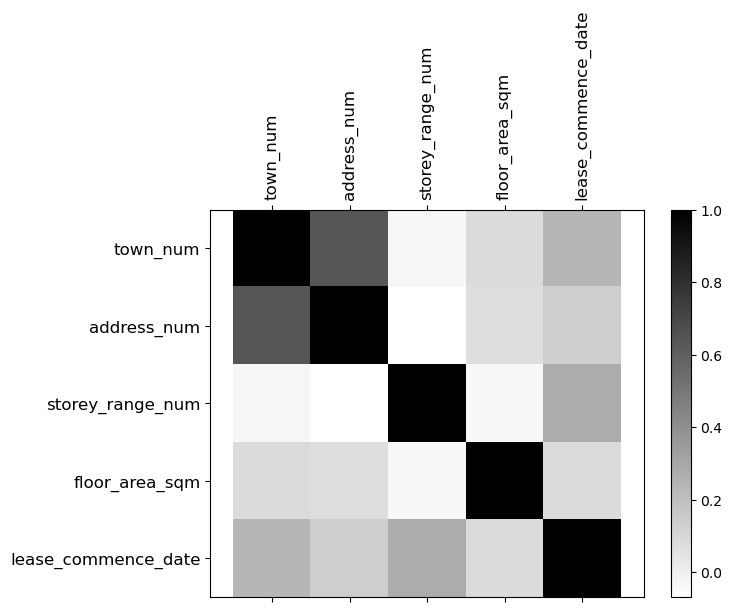

In [28]:
f = plt.figure(figsize = (7, 5))
plt.matshow(X.corr(), fignum = f.number, cmap = "binary")
plt.xticks(range(X.shape[1]), X.columns, fontsize = 12, rotation = 90)
plt.yticks(range(X.shape[1]), X.columns, fontsize = 12)
plt.axis('equal')
plt.colorbar()
plt.show()

`floor_area_sqm` seems to be correlated to `flat_type`/`flat_model`, which is reasonable as higher-quality flats in general tend to be larger in space. Other than that, there does not seem to exist any very highly correlated features (but then again there are only a few features here...).

`address_num` and `town_num` are strongly correlated (as they should be!). Therefore it might be good to choose to use either `address_num` or `town_num` in the model, and not both at the same time! `address_num` will give us more precision in the location of the properties, while `town_num` gives a more generic location.

Post analysis comments:
Research has shown that using `town_num` leads to a more accurate model than using `address_num`! Perhaps this is because `address_num` is far too localised?

## Scaling the Data Distribution for Model Training

Check the distribution of the resale flat prices!

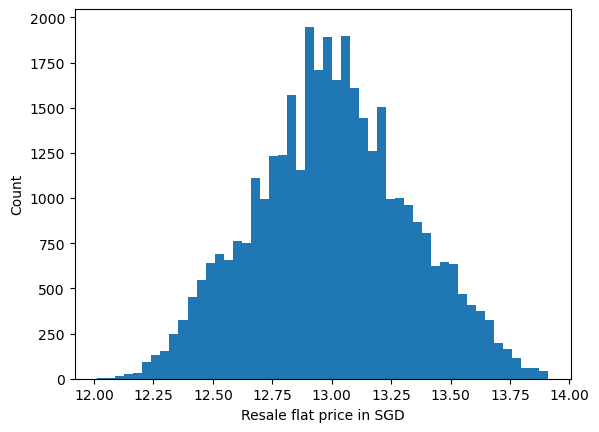

In [45]:
plt.hist(y, 50)
plt.xlabel("Resale flat price in SGD")
plt.ylabel("Count")
plt.show()

The distribution is skewed to the right, which make sense. Usually there are many "cheap" aparments and a few "expensive" ones.

In general, for regression models, the target should follow a Gaussian distribution for best performance. Therefore we should apply a `log` function to the target variable!

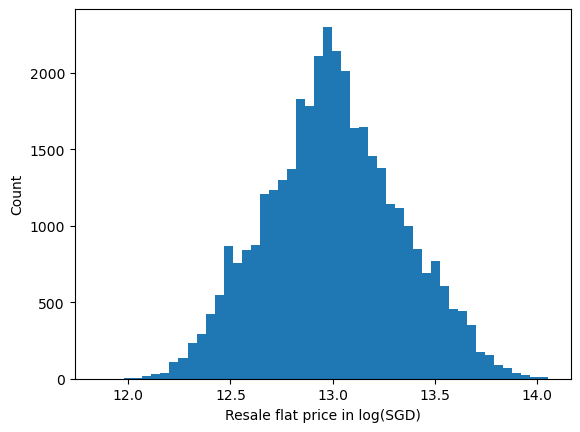

In [30]:
# Perform corrections to the resale price distribution by applying a log function to y:
y = np.log(y)

plt.hist(y, 50)
plt.xlabel("Resale flat price in log(SGD)")
plt.ylabel("Count")
plt.show()

The log price is certainly more normally distributed than the non-log price! Use this instead in the model!
to get the original price, take `np.exp(y_pred)`.

In [31]:
print(y.describe())

count    36610.000000
mean        13.004529
std          0.328889
min         11.849398
25%         12.779873
50%         12.994530
75%         13.217674
max         14.052951
Name: resale_price, dtype: float64


Check the distribution of the floor area.

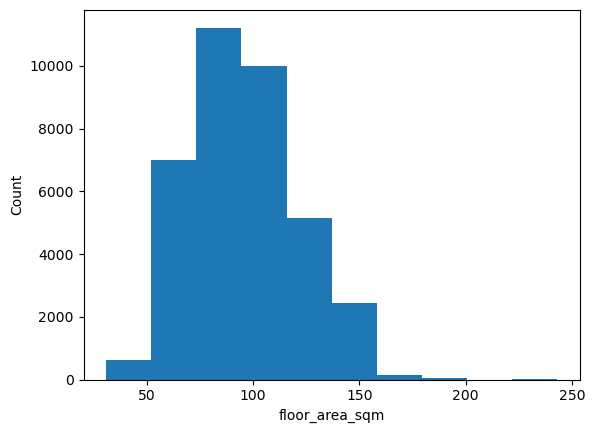

In [32]:
plt.hist(X["floor_area_sqm"])
plt.xlabel("floor_area_sqm")
plt.ylabel("Count")
plt.show()

# The floor area is also right skewed...

In [33]:
print(X["floor_area_sqm"].describe())

count    36610.000000
mean        97.868266
std         24.098743
min         31.000000
25%         83.000000
50%         93.000000
75%        113.000000
max        243.000000
Name: floor_area_sqm, dtype: float64


Check the distributions for floor area and price!

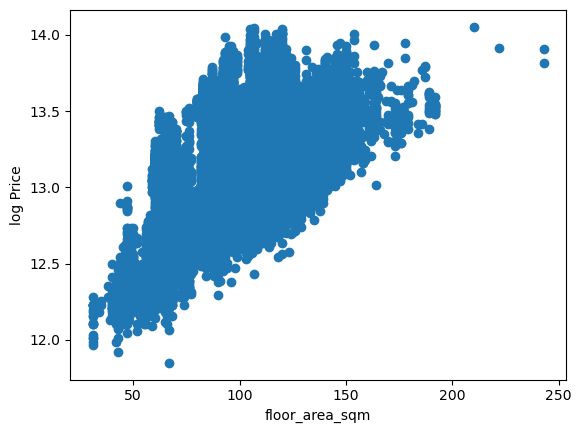

In [34]:
plt.plot(X['floor_area_sqm'], y, 'o')
plt.xlabel('floor_area_sqm')
plt.ylabel('log Price')
plt.show()

So it looks like there are some outliers present in the data! It might be useful to remove those outliers from the data used to construct the model...

Check the distribution between age (lease commencement date) vs. price. In general old flats should be cheaper and new flats should be more expensive!

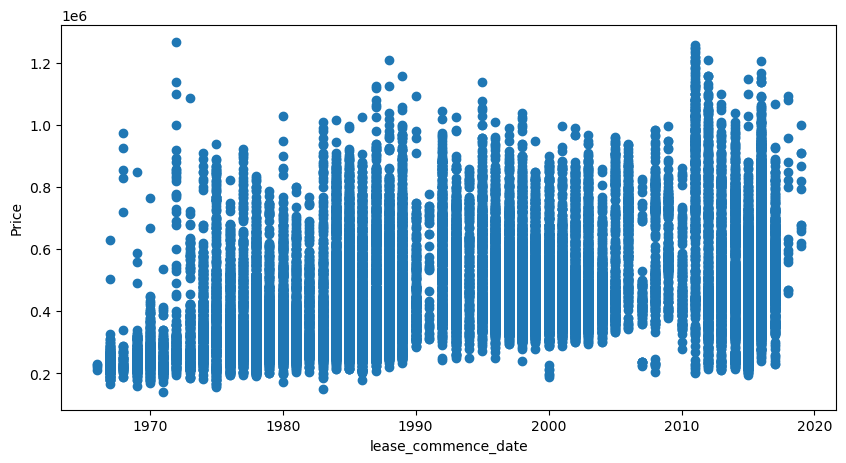

In [35]:
plt.figure(figsize=(10,5))
plt.plot(X['lease_commence_date'],np.exp(y),'o')
plt.xlabel('lease_commence_date')
plt.ylabel('Price')
plt.show()

While there is a mild trend that lease commence dates from 1970 are lower than those from 2010, there does not seem to exist any significant trend or relationship, especially for leases after 1980...

Check the distribution between lease commence date and floor area...

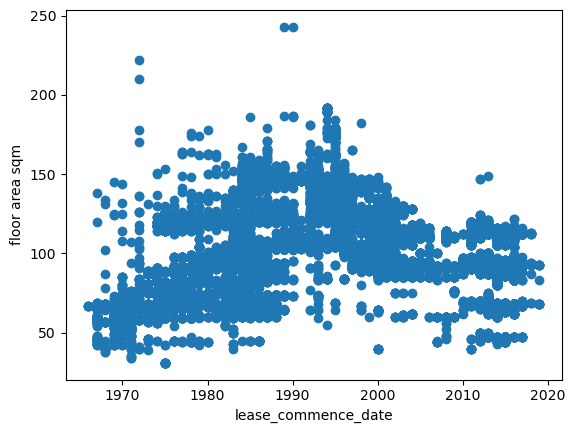

In [36]:
plt.plot(X['lease_commence_date'], X['floor_area_sqm'], 'o')
plt.xlabel('lease_commence_date')
plt.ylabel('floor area sqm')
plt.show()

It would seem that old flats from 1970 and new flats from 2000 are small! While the majority of large flats were built from 1985 to about 1995!

Remove outliers from X and y...

For the current data set, outlier removal can only be done for floor_area_sqm and resale price. The other data consist mainly of numerically encoded categorical variables!

In [37]:
# remove all excessively large apartments
condn1 = np.array(X["floor_area_sqm"] < 180)
# remove all excessively small apartments
condn2 = np.array(X["floor_area_sqm"] > 38)
# remove all excessively cheap apartments
condn3 = np.array(y >= 12.0)
# remove all excessively expensive apartments
condn4 = np.array(y <= np.log(1100000))

outliers_condn = condn1 & condn2 & condn3 & condn4

X = X[outliers_condn]
y = y[outliers_condn]

print("Feature shape with outliers removed:",X.shape)
print("Target shape with outliers removed:",y.shape)

Feature shape with outliers removed: (36493, 5)
Target shape with outliers removed: (36493,)


Check the distribution again one more time after removing the outliers.

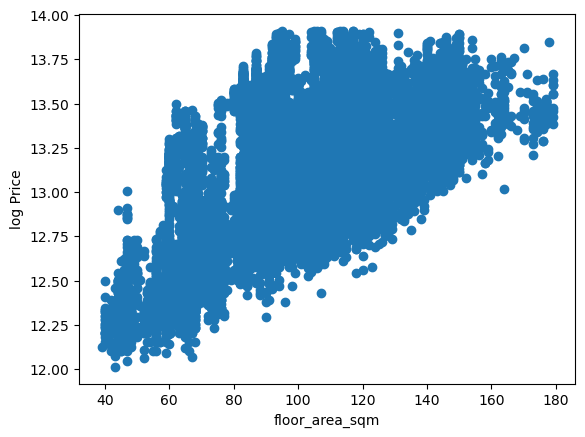

In [39]:
plt.plot(X['floor_area_sqm'], y, 'o')
plt.xlabel('floor_area_sqm')
plt.ylabel('log Price')
plt.show()

The distribution looks a lot better this time round! It should be relatively safe to proceed with the modelling...

Before we do any modeling, we need to make training and testing data for cross validation!

Split the data into training and testing data sets!

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(np.shape(X_train),np.shape(X_test),np.shape(y_train),np.shape(y_test))

(27369, 5) (9124, 5) (27369,) (9124,)


## Part 4

In this part, we train a model to predict the resale flat prices using the cleaned data from above.

As the data is not normalized, we use decision tree based methods. In particular, we use a gradient boosted machine model which is able to adapt learn from its own mistakes during the training process, making it more powerful than random forests.

In [71]:
lg = LGBMRegressor(n_estimators = 500, num_leaves = 2 ** 5, max_depth = 5, objective = "mse")
lg.fit(X_train,y_train)

print("Train mse: {:.3f}".format(mean_squared_error(y_train, lg.predict(X_train))))
print("Test mse: {:.3f}".format(mean_squared_error(y_test, lg.predict(X_test))))

y_pred = lg.predict(X_test)

Train mse: 0.005
Test mse: 0.005


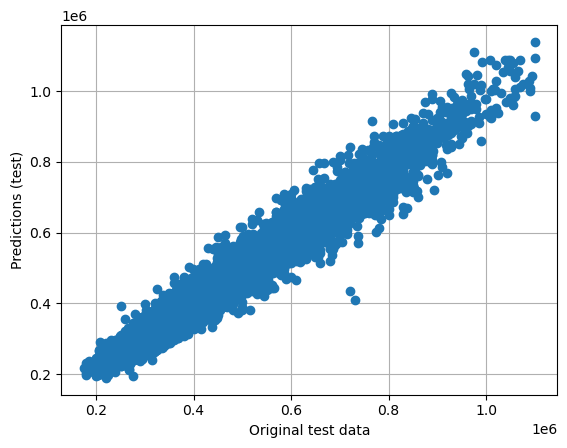

In [72]:
plt.plot(np.exp(y_test), np.exp(y_pred), 'o')
plt.xlabel('Original test data')
plt.ylabel('Predictions (test)')
plt.grid('on')
plt.show()

# comment: it would also appear that the spread of predictions is much tighter than that of the random
# forest regressor

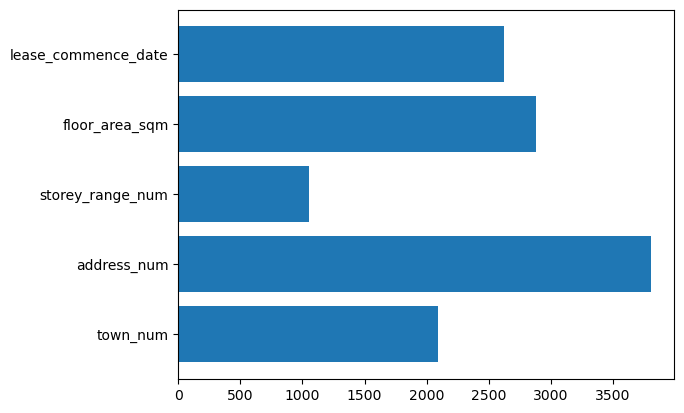

In [73]:
plt.barh(X.columns, lg.feature_importances_)
plt.show()